In [2]:
%load_ext autoreload
%autoreload 2
%aimport -fenics
%aimport -numpy 
%aimport -matplotlib
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import settings
import solution_io
import ice_physics


In [3]:

yr2sec = 365.25 * 24 * 60 * 60
experiment = settings.experiment(resolution_l=10,resolution_w=10,resolution_h=5)
domain_w = experiment["domain_w"]
domain_h = experiment["domain_h"]
domain_l = experiment["domain_l"]
resolution_w = experiment["resolution_w"]
resolution_h = experiment["resolution_h"]
resolution_l = experiment["resolution_l"]
icestream_width = experiment["icestream_width"]
shearmargin_enhancement = experiment["shearmargin_enhancement"]
shearmargin_enhancement_pos = experiment["shearmargin_enhancement_pos"]
icestream_Exx = experiment["icestream_Exx"]
A = experiment["A"]
rho = experiment["rho"]
n = experiment["n"]
gmag = experiment["gmag"]
alpha = experiment["alpha"]
beta = experiment["weertman_beta"]


In [9]:
#LOAD 2d results...
use2dresults = False
if use2dresults:
    fname2d = settings.filename2d(experiment)
    result2d = solution_io.load_solution(fname2d)
    p2dfun = result2d["p"]
    v2dfun = result2d["u"]
    p2dfun.set_allow_extrapolation(True)
    v2dfun.set_allow_extrapolation(True)

    class pressure2d(UserExpression):
        def eval(self, values, x):
            values[0] = p2dfun((x[1], x[2]))  # meaning of x,y, and z are different in 2d vs 3d versions

        def value_shape(self):
            return ()

    class vel2d(UserExpression):
        def eval(self, values, x):
            v=v2dfun((x[1], x[2]))
            values[0] = v[2]  # meaning of x,y, and z are different in 2d vs 3d versions
            values[1] = 0
            values[2] = 0

        def value_shape(self):
            return (3,)


Coefficient(FunctionSpace(None, FiniteElement('Lagrange', None, 2)), 97)

In [51]:
if experiment["model_half"]:
    mesh = BoxMesh(Point(0, 0, 0), Point(domain_l, +domain_w / 2, domain_h), resolution_l, resolution_w, resolution_h)
else:
    mesh = BoxMesh(Point(0, -domain_w / 2, 0), Point(domain_l, +domain_w / 2, domain_h), resolution_l, resolution_w, resolution_h)

# mesh refinement.
for x in mesh.coordinates():
    x[2] = (x[2] / domain_h) ** 1.7 * domain_h
    amp = icestream_width / 10
    if abs(x[1]) < (icestream_width * 0.75):
        x[1] += np.sin((x[1] / icestream_width - 1) * 2 * np.pi) * amp
    else:
        x[1] += (abs(x[1]) - domain_w / 2) / ((domain_w / 2 - icestream_width * 0.75)) * amp


In [52]:

Uele = VectorElement("CG", mesh.ufl_cell(), 2)
Pele = FiniteElement("CG", mesh.ufl_cell(), 1)

MixedEle = MixedElement([Uele, Pele])

U = VectorFunctionSpace(mesh, "CG", 2)
P = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, MixedEle)

(u, p) = TrialFunctions(W)  # the unknowns
(v, q) = TestFunctions(W)  # the weighting funcs
w = Function(W)


e_x = Expression(("1.0", "0.0", "0.0"), element=Uele)
e_y = Expression(("0.0", "1.0", "0.0"), element=Uele)
e_z = Expression(("0.0", "0.0", "1.0"), element=Uele)


In [53]:
#BCs
near = lambda a, b: abs(a - b) < 0.1
bottom_noslip = lambda x, on_boundary: on_boundary and near(x[2], 0) and (abs(x[1]) >= icestream_width / 2)
bottom = lambda x, on_boundary: on_boundary and near(x[2], 0)
side = lambda x, on_boundary: on_boundary and near(abs(x[1]), domain_w / 2)
icedivide = lambda x, on_boundary: on_boundary and near(abs(x[0]), 0)
front = lambda x, on_boundary: on_boundary and near(x[0], domain_l)
top = lambda x, on_boundary: on_boundary and near(x[2], domain_h)
centerline = lambda x, on_boundary: on_boundary and near(x[1], 0)

class bottom_weertman(SubDomain):
    def inside(self, x, on_boundary):
        return bottom(x, on_boundary) and not bottom_noslip(x, on_boundary)

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
bottom_weertman().mark(boundaries, 1)
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)


hydrostatic_pressure = Expression("dpdz*(H-x[2])", H=domain_h, dpdz=rho * gmag / np.cos(alpha), degree=2)
# set pressure at front boundary to 2d solution



bc = [DirichletBC(W.sub(1), Constant(0), top)]
bc += [DirichletBC(W.sub(0).sub(0), Constant(0), bottom_noslip)]
bc += [DirichletBC(W.sub(0).sub(1), Constant(0), bottom_noslip)]
bc += [DirichletBC(W.sub(0).sub(2), Constant(0), bottom)]
bc += [DirichletBC(W.sub(0).sub(1), Constant(0), side)]
bc += [DirichletBC(W.sub(0).sub(0), Constant(0), icedivide)]
if experiment["model_half"]:
    bc += [DirichletBC(W.sub(0).sub(1), Constant(0), centerline)]

# bc += [DirichletBC(W.sub(0).sub(1), Constant(0), front)]
# bc += [DirichletBC(W.sub(0).sub(2), Constant(0), front)]
#bc += [DirichletBC(W.sub(1), hydrostatic_pressure, icedivide)]
#bc += [DirichletBC(W.sub(1), hydrostatic_pressure, front)]
#bc += [DirichletBC(W.sub(1), pressure2d(degree=2), front)]
#bc += [DirichletBC(W.sub(0), vel2d(degree=2), front)]

# https://bitbucket.org/fenics-project/dolfin/issues/252/function-assignment-failing-with-mixed
p0 = interpolate(hydrostatic_pressure, P)
assign(w.sub(1), p0)
if use2dresults:
    v0 = interpolate(vel2d(degree=2), U)
    assign(w.sub(0), v0)


In [54]:
E_spatial = Expression(
    "1+E*exp(-0.5*pow((pos-abs(x[1]))/sigma,2))", pos=shearmargin_enhancement_pos, sigma=1e3, E=shearmargin_enhancement, degree=2,
)
q_degree = 7
dx = dx(metadata={'quadrature_degree': q_degree})

def a_fun(n):
    if n == 1:
        AA = A * 2.2e10  
    else:
        AA = A  
    eps = ice_physics.strainrate(u)
    #tau = ice_physics.tau(eps, AA * E_spatial, n)
    if icestream_Exx!=1:
        Exx = Expression("1+(Exx-1)./(1+exp(-((iw -abs(x')))/1e3))",iw=icestream_width,Exx=icestream_Exx)
    tau = ice_physics.tau_orthotropic(eps, AA, n, Exx, 1, 1, E_spatial, 1, 1)
    a = (inner(sym(grad(v)), tau) - div(v) * p + q * div(u)) * dx
    a += beta * dot(v, u) * ds(1)
    return a



g = Constant((sin(alpha) * gmag * rho, 0, -cos(alpha) * gmag * rho))  # grav vec
L = inner(v, g) * dx




In [55]:

solver_parameters = {"linear_solver": "mumps", "preconditioner": "petsc_amg"}
solve(a_fun(n=1) == L, w, bc, solver_parameters=solver_parameters)
(usol, psol) = w.split(deepcopy=True)


Calling FFC just-in-time (JIT) compiler, this may take some time.
    Solving linear variational problem.


In [56]:
if n != 1:  # NLIN
    print("NON-LINEAR SOLVE!")
    F = a_fun(n) - L
    R = action(F, w)
    DR = derivative(R, w)  # Gateaux derivative
    problem = NonlinearVariationalProblem(R, w, bc, DR)
    solver = NonlinearVariationalSolver(problem)
    prm = solver.parameters
    prm["newton_solver"]["linear_solver"] = "mumps"  # ?
    prm["newton_solver"]["relative_tolerance"] = 1e-4
    prm["newton_solver"]["absolute_tolerance"] = 1e-3
    prm["newton_solver"]["relaxation_parameter"] = 0.41
    prm["newton_solver"]["maximum_iterations"] = 30  # 100?
    prm["newton_solver"]["convergence_criterion"] = "incremental"
    # -------------------
    prm["newton_solver"]["report"] = True
    prm["newton_solver"]["error_on_nonconvergence"] = False
    prm["newton_solver"]["krylov_solver"]["report"] = True
    prm["newton_solver"]["krylov_solver"]["monitor_convergence"] = True
    prm["newton_solver"]["krylov_solver"]["nonzero_initial_guess"] = True
    prm["newton_solver"]["krylov_solver"]["error_on_nonconvergence"] = False

    solver.solve()
else:
    print(f"n=1 - so skipping non-linear solver.")

(usol, psol) = w.split(deepcopy=True)

NON-LINEAR SOLVE!
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 4.273e+06 (tol = 1.000e-03) r (rel) = 1.000e+00 (tol = 1.000e-04)
      Newton iteration 1: r (abs) = 2.854e+06 (tol = 1.000e-03) r (rel) = 6.681e-01 (tol = 1.000e-04)
      Newton iteration 2: r (abs) = 1.723e+06 (tol = 1.000e-03) r (rel) = 4.033e-01 (tol = 1.000e-04)
      Newton iteration 3: r (abs) = 9.732e+05 (tol = 1.000e-03) r (rel) = 2.278e-01 (tol = 1.000e-04)
      Newton iteration 4: r (abs) = 5.363e+05 (tol = 1.000e-03) r (rel) = 1.255e-01 (tol = 1.000e-04)
      Newton iteration 5: r (abs) = 2.978e+05 (tol = 1.000e-03) r (rel) = 6.969e-02 (tol = 1.000e-04)
      Newton iteration 6: r (abs) = 1.685e+05 (tol = 1.000e-03) r (rel) = 3.944e-02 (tol = 1.000e-04)
      Newton iteration 7: r (abs) = 9.697e+04 (tol = 1.000e-03) r (rel) = 2.269e-02 (tol = 1.

Text(0.5, 1.0, 'Vmag m/yr')

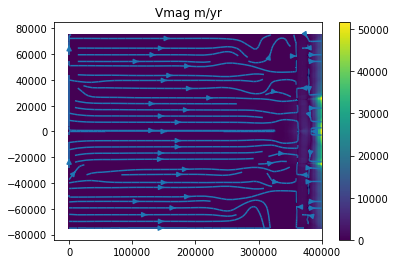

In [57]:
x = np.linspace(0, domain_l, 200)
y = np.linspace(-domain_w / 2, domain_w / 2, 200)
[X, Y] = np.meshgrid(x, y)
Vx = np.empty(X.shape)
Vy = np.empty(X.shape)
Pmap = np.empty(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        v = usol(X[r, c], np.abs(Y[r, c]), domain_h)
        Vx[r, c] = v[0]
        Vy[r, c] = v[1] * np.sign(Y[r, c])
        Pmap[r, c] = psol(X[r, c], np.abs(Y[r, c]), 0)
V = np.sqrt(Vx ** 2 + Vy ** 2)
plt.pcolormesh(X, Y, V * yr2sec)
plt.colorbar()
plt.streamplot(X, Y, Vx, Vy)
np.max(V * yr2sec)
plt.title("Vmag m/yr")

In [58]:
print(psol(domain_l-0.1,0.1,0.1))
p2d = pressure2d(degree=2)
print(p2d(domain_l-0.1,0.1,0.1))

17990720.905469127
17990559.465178702
